In [46]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras import activations
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, LSTM, Activation, Dropout
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [15]:
img = pd.read_pickle("data/gear_img_df.pkl").values
gear = pd.read_pickle("data/gear_name_df.pkl").values
img_reshape = img.reshape(2122, 128, 128, 3)

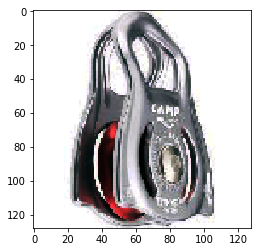

In [16]:
plt.imshow(img_reshape[2])

In [17]:
categories = np.unique(gear)
n_categories = len(categories)
ohe_labels = np.zeros((len(gear), n_categories))
for ii in range(len(gear)):
    jj = np.where(categories == gear[ii])
    ohe_labels[ii, jj] = 1

In [7]:
img_reshape = img_reshape.astype('float32') / 255

In [8]:
train_data, test_data, train_labels, test_labels= train_test_split(img_reshape, ohe_labels, random_state=0)

In [9]:
train_data.shape[1:]

(128, 128, 3)

In [92]:
# Initializes a sequential mode
model = Sequential()
model.add(Conv2D(15, kernel_size=1, activation='relu', padding="valid", strides=1, input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=3, padding="valid"))
model.input_shape
model.output_shape

(None, 42, 42, 15)

In [24]:
# Initializes a sequential mode
model = Sequential() 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3))) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(12, activation = 'softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_data.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(12))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
model.fit(train_data, train_labels, validation_split=0.2, epochs=5)

Train on 1272 samples, validate on 319 samples
Epoch 1/5
1272/1272 [==============================] - 22s 17ms/step - loss: 1.3931 - acc: 0.5472 - val_loss: 0.7140 - val_acc: 0.7524
Epoch 2/5
1272/1272 [==============================] - 22s 17ms/step - loss: 0.4324 - acc: 0.8781 - val_loss: 0.5368 - val_acc: 0.8495
Epoch 3/5
1272/1272 [==============================] - 22s 17ms/step - loss: 0.2110 - acc: 0.9387 - val_loss: 0.3673 - val_acc: 0.8746
Epoch 4/5
1272/1272 [==============================] - 22s 17ms/step - loss: 0.0688 - acc: 0.9819 - val_loss: 0.3088 - val_acc: 0.9060
Epoch 5/5
1272/1272 [==============================] - 22s 17ms/step - loss: 0.0401 - acc: 0.9874 - val_loss: 0.3060 - val_acc: 0.9185


In [26]:
test_loss, test_acc = model.evaluate(test_data, test_labels)

531/531 [==============================] - 3s 5ms/step


In [27]:
print('test_acc:', test_acc)

test_acc: 0.9190207156308852


In [31]:
!mkdir output

In [86]:
model_json = model.to_json()
with open("output/model.json", "w") as json_file:
    json_file.write(model_json)

In [87]:
model.save_weights("output/model.h5")

In [33]:
model

In [93]:
json_file = open('output/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("output/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [95]:
with open('output/model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("output/model.h5")
print("Loaded Model from disk")

Loaded Model from disk


In [35]:
from keras.models import model_from_json

In [96]:
loaded_model.predict(test_data[1].reshape((1,) + test_data[1].shape))

array([[1.2102885e-07, 2.5053414e-06, 5.0729077e-06, 9.9778384e-01,
        3.2700470e-06, 3.3430237e-07, 3.5517935e-06, 3.4646523e-06,
        6.7957885e-06, 1.7579390e-07, 1.4469973e-05, 2.1764832e-03]],
      dtype=float32)

In [59]:
from PIL import Image, ImageOps
from keras.preprocessing.image import img_to_array
def prepare_image(image, target):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image_w, image_h, image_ch = img_to_array(image).shape
    delta_w, delta_h = max(image_w, image_h) - image_w, max(image_w, image_h) - image_h
    padding = (delta_h//2, delta_w//2, delta_h - (delta_h//2), delta_w - delta_w//2) 
    return img_to_array(ImageOps.equalize(ImageOps.expand(image, padding, fill="white").resize(target))) / 255.0

In [60]:
image = prepare_image(Image.open("./gear_images/tents/10093614x1052425_zm.jpeg"), (128, 128))

In [61]:
preds = model.predict(image.reshape(((1,) + image.shape)))

In [70]:
categories[preds.argmax()]

'tents'

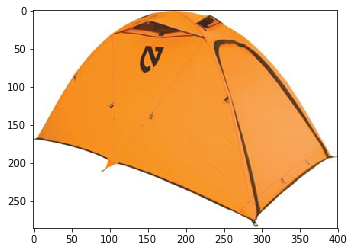

In [66]:
plt.imshow(Image.open("./gear_images/tents/10093614x1052425_zm.jpeg"))

In [120]:
[float(pred) for pred in preds.ravel()]

[3.860251528153835e-12,
 1.874531779799682e-11,
 4.413518439605468e-08,
 2.2620773961534724e-05,
 2.9917239317001076e-06,
 1.597513588080801e-08,
 1.26370665043396e-07,
 6.281281744735523e-11,
 4.4191395431880665e-07,
 3.1757277363375636e-11,
 5.18218030265416e-07,
 0.9999732971191406]

In [1]:
gear_categories = ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets','pulleys', 'rope', 'tents']

In [4]:
!mkdir openhack-nb && mv challenge-1.ipynb openhack-nb/challenge-1.ipynb